# Modelo usando redes convolucionales

## Paso 1: Montar Google Drive y cargar datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import os

# Directorio con los archivos procesados
output_dir = "/content/drive/MyDrive/processed_data"
processed_files = [f for f in os.listdir(output_dir) if f.endswith('_II.npy')]

signals = []
labels = []

for filename in processed_files:
    full_signal_path = os.path.join(output_dir, filename)
    data = np.load(full_signal_path, allow_pickle=True).item()
    signals.append(data['signal'])
    labels.append(data['labels'])

signals = np.array(signals, dtype=object)
labels = np.array(labels, dtype=object)

print("Señales cargadas:", signals.shape)
print("Etiquetas cargadas:", labels.shape)


Mounted at /content/drive
Señales cargadas: (740,)
Etiquetas cargadas: (740, 2)


##Paso 2: Normalización Z-score

In [ ]:
def z_score_normalization(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    return (signal - mean) / std

normalized_signals = [z_score_normalization(signal) for signal in signals]
normalized_signals = np.array(normalized_signals, dtype=object)

print("Señales normalizadas")


<ipython-input-2-a81922d10e65>:4: RuntimeWarning: invalid value encountered in divide
  return (signal - mean) / std


Señales normalizadas


## Paso 3: Implementación del detector de picos R

In [ ]:
from scipy.signal import butter, lfilter

def bandpass_filter(signal, lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def derivative(signal):
    b = [1, 2, 0, -2, -1]
    a = 8
    return lfilter(b, a, signal)

def squaring(signal):
    return signal ** 2

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def detect_r_peaks(signal, fs):
    filtered_signal = bandpass_filter(signal, 5, 15, fs, order=1)
    derivative_signal = derivative(filtered_signal)
    squared_signal = squaring(derivative_signal)
    window_size = int(0.12 * fs)
    averaged_signal = moving_average(squared_signal, window_size)
    peaks = []
    threshold = np.mean(averaged_signal)
    for i in range(1, len(averaged_signal) - 1):
        if averaged_signal[i] > threshold and averaged_signal[i] > averaged_signal[i - 1] and averaged_signal[i] > averaged_signal[i + 1]:
            peaks.append(i)
    return np.array(peaks)

print("Detector de picos R implementado")


Detector de picos R implementado


##Paso 4: Segmentación de las señales

In [ ]:
def segment_signal(signal, r_peaks, segment_length=360):
    segments = []
    half_length = segment_length // 2
    for r in r_peaks:
        if r - half_length >= 0 and r + half_length < len(signal):
            segments.append(signal[r - half_length:r + half_length])
    return np.array(segments)

fs = 250  # Frecuencia de muestreo de tus señales ECG (ajústalo según tus datos)
segmented_signals = [segment_signal(signal, detect_r_peaks(signal, fs)) for signal in normalized_signals]
segmented_signals = np.array(segmented_signals, dtype=object)

print("Señales segmentadas")


Señales segmentadas


## Paso 5: Preparar datos para el modelo con manejo de etiquetas dobles


**Parte 1:** Asegurarse de que todas las señales segmentadas tengan la misma cantidad de dimensiones y filtrar

In [ ]:
# Filtrar las señales que no tienen la longitud deseada
filtered_segmented_signals = []
filtered_labels = []

for signal_segments, label_set in zip(segmented_signals, labels):
    valid_segments = [seg for seg in signal_segments if len(seg) == 360]
    if valid_segments:
        filtered_segmented_signals.extend(valid_segments)
        filtered_labels.extend([label_set] * len(valid_segments))

filtered_segmented_signals = np.array(filtered_segmented_signals).reshape(-1, 360, 1)
filtered_labels = np.array(filtered_labels)

print("Señales segmentadas y filtradas:", filtered_segmented_signals.shape)
print("Etiquetas correspondientes:", filtered_labels.shape)


Señales segmentadas y filtradas: (851309, 360, 1)
Etiquetas correspondientes: (851309, 2)


**Parte 2:** Gestionar las etiquetas dobles (falsa/verdadera y tipo de arritmia)
Aquí organizamos las etiquetas para reflejar tanto la naturaleza de la alarma como el tipo de arritmia:

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Mapear etiquetas a valores numéricos
alarm_map = {'#False alarm': 0, '#True alarm': 1}
arrhythmia_map = {'#Asystole': 0, '#Bradycardia': 1, '#Tachycardia': 2, '#Ventricular_Flutter_Fib': 3, '#Ventricular_Tachycardia': 4}

# Convertir etiquetas a formato numérico
alarm_labels = np.array([alarm_map[label[1]] for label in filtered_labels])
arrhythmia_labels = np.array([arrhythmia_map[label[0]] for label in filtered_labels])

# Convertir a formato categórico
alarm_labels_categorical = to_categorical(alarm_labels, num_classes=2)
arrhythmia_labels_categorical = to_categorical(arrhythmia_labels, num_classes=5)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train_alarm, y_test_alarm = train_test_split(filtered_segmented_signals, alarm_labels_categorical, test_size=0.2, random_state=42)
_, _, y_train_arrhythmia, y_test_arrhythmia = train_test_split(filtered_segmented_signals, arrhythmia_labels_categorical, test_size=0.2, random_state=42)

print("Datos preparados para el modelo:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_alarm shape:", y_train_alarm.shape)
print("y_test_alarm shape:", y_test_alarm.shape)
print("y_train_arrhythmia shape:", y_train_arrhythmia.shape)
print("y_test_arrhythmia shape:", y_test_arrhythmia.shape)


Datos preparados para el modelo:
X_train shape: (681047, 360, 1)
X_test shape: (170262, 360, 1)
y_train_alarm shape: (681047, 2)
y_test_alarm shape: (170262, 2)
y_train_arrhythmia shape: (681047, 5)
y_test_arrhythmia shape: (170262, 5)


## Paso 6: Definir y entrenar el modelo CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Concatenate

# Definir las entradas
input_layer = Input(shape=(360, 1))

# Definir la arquitectura compartida del modelo
conv1 = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(64, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
flatten = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Definir la salida de alarm_output
alarm_output = Dense(2, activation='softmax', name='alarm_output')(dropout2)

# Definir la salida de arrhythmia_output
arrhythmia_output = Dense(5, activation='softmax', name='arrhythmia_output')(dropout2)

# Crear el modelo
model = Model(inputs=input_layer, outputs=[alarm_output, arrhythmia_output])

# Compilar el modelo
model.compile(optimizer='adam',
              loss={'alarm_output': 'categorical_crossentropy', 'arrhythmia_output': 'categorical_crossentropy'},
              metrics={'alarm_output': 'accuracy', 'arrhythmia_output': 'accuracy'})

# Entrenar el modelo
history = model.fit(X_train,
                    {'alarm_output': y_train_alarm, 'arrhythmia_output': y_train_arrhythmia},
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, {'alarm_output': y_test_alarm, 'arrhythmia_output': y_test_arrhythmia}))

print("Modelo entrenado")


Epoch 1/20
21283/21283 [==============================] - 136s 6ms/step - loss: 1.2377 - alarm_output_loss: 0.3851 - arrhythmia_output_loss: 0.8526 - alarm_output_accuracy: 0.8340 - arrhythmia_output_accuracy: 0.6818 - val_loss: 0.7792 - val_alarm_output_loss: 0.2391 - val_arrhythmia_output_loss: 0.5401 - val_alarm_output_accuracy: 0.9034 - val_arrhythmia_output_accuracy: 0.8017
Epoch 2/20
21283/21283 [==============================] - 128s 6ms/step - loss: 0.9101 - alarm_output_loss: 0.2760 - arrhythmia_output_loss: 0.6341 - alarm_output_accuracy: 0.8895 - arrhythmia_output_accuracy: 0.7716 - val_loss: 0.6571 - val_alarm_output_loss: 0.1943 - val_arrhythmia_output_loss: 0.4628 - val_alarm_output_accuracy: 0.9235 - val_arrhythmia_output_accuracy: 0.8322
Epoch 3/20
21283/21283 [==============================] - 128s 6ms/step - loss: 0.8093 - alarm_output_loss: 0.2415 - arrhythmia_output_loss: 0.5678 - alarm_output_accuracy: 0.9048 - arrhythmia_output_accuracy: 0.7971 - val_loss: 0.5970 

In [ ]:
# Mostrar el resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 1)]             0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 358, 64)              256       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 179, 64)              0         ['conv1d_3[0][0]']            
 g1D)                                                                                             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 177, 64)              12352     ['max_pooling1d_3[0][0]'] 

## Paso 7: Evaluar el modelo


In [ ]:
# Evaluar el modelo
loss, alarm_loss, arrhythmia_loss, alarm_accuracy, arrhythmia_accuracy = model.evaluate(X_test,
                                                                                       {'alarm_output': y_test_alarm,
                                                                                        'arrhythmia_output': y_test_arrhythmia})
print(f'Precisión de alarmas en el conjunto de prueba: {alarm_accuracy * 100:.2f}%')
print(f'Precisión de arritmias en el conjunto de prueba: {arrhythmia_accuracy * 100:.2f}%')


5321/5321 [==============================] - 15s 3ms/step - loss: 0.4491 - alarm_output_loss: 0.1213 - arrhythmia_output_loss: 0.3277 - alarm_output_accuracy: 0.9534 - arrhythmia_output_accuracy: 0.8817
Precisión de alarmas en el conjunto de prueba: 95.34%
Precisión de arritmias en el conjunto de prueba: 88.17%


## Paso 8: Evaluar el modelo en detalle


In [ ]:
from sklearn.metrics import classification_report

# Predicciones
y_pred_alarm, y_pred_arrhythmia = model.predict(X_test)

# Convertir predicciones de probabilidades a etiquetas
y_pred_alarm_labels = np.argmax(y_pred_alarm, axis=1)
y_pred_arrhythmia_labels = np.argmax(y_pred_arrhythmia, axis=1)

# Convertir etiquetas de prueba a formato categórico
y_test_alarm_labels = np.argmax(y_test_alarm, axis=1)
y_test_arrhythmia_labels = np.argmax(y_test_arrhythmia, axis=1)

# Generar reporte de clasificación para alarmas
print("Reporte de clasificación para alarmas:")
print(classification_report(y_test_alarm_labels, y_pred_alarm_labels, target_names=['False alarm', 'True alarm']))

# Generar reporte de clasificación para arritmias
print("Reporte de clasificación para arritmias:")
print(classification_report(y_test_arrhythmia_labels, y_pred_arrhythmia_labels, target_names=['Asystole', 'Bradycardia', 'Tachycardia', 'Ventricular Flutter/Fib', 'Ventricular Tachycardia']))


5321/5321 [==============================] - 10s 2ms/step
Reporte de clasificación para alarmas:
              precision    recall  f1-score   support

 False alarm       0.94      0.98      0.96    104650
  True alarm       0.97      0.91      0.94     65612

    accuracy                           0.95    170262
   macro avg       0.96      0.94      0.95    170262
weighted avg       0.95      0.95      0.95    170262

Reporte de clasificación para arritmias:
                         precision    recall  f1-score   support

               Asystole       0.91      0.79      0.84     27664
            Bradycardia       0.97      0.78      0.87     14629
            Tachycardia       0.95      0.93      0.94     37389
Ventricular Flutter/Fib       0.90      0.62      0.73     14731
Ventricular Tachycardia       0.83      0.96      0.89     75849

               accuracy                           0.88    170262
              macro avg       0.91      0.82      0.85    170262
           we

## Paso 9: Visualización de las métricas del entrenamiento


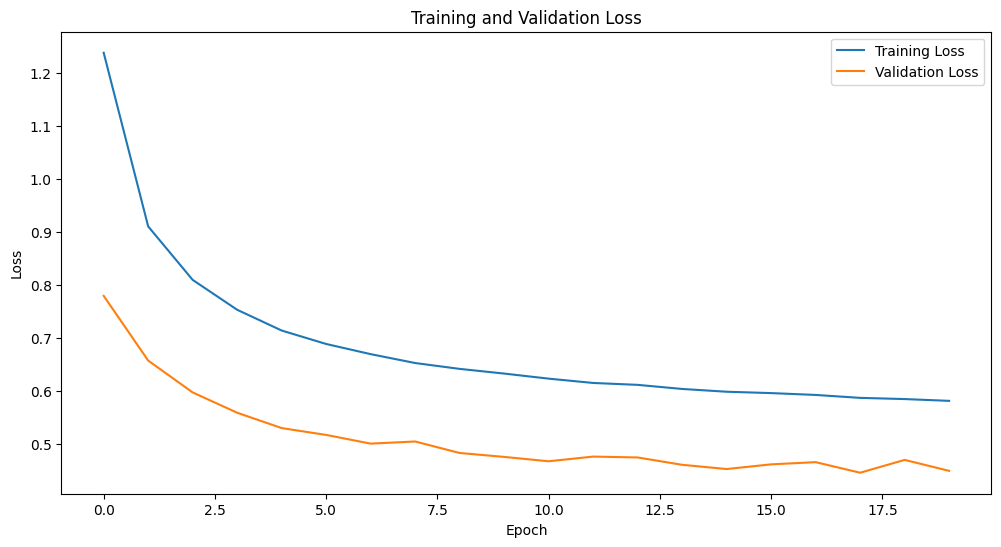

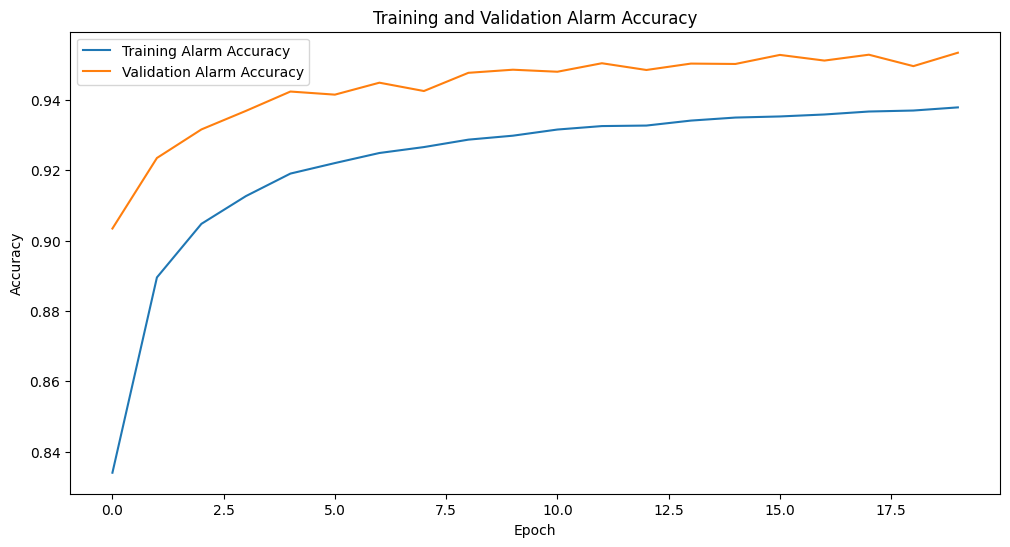

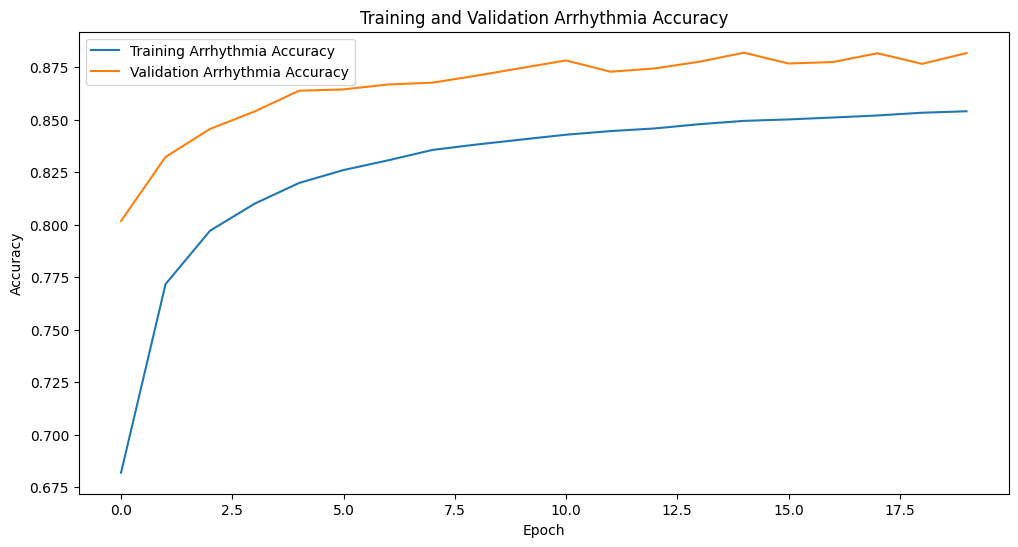

In [ ]:
import matplotlib.pyplot as plt

# Visualizar pérdida
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizar precisión de alarma
plt.figure(figsize=(12, 6))
plt.plot(history.history['alarm_output_accuracy'], label='Training Alarm Accuracy')
plt.plot(history.history['val_alarm_output_accuracy'], label='Validation Alarm Accuracy')
plt.title('Training and Validation Alarm Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizar precisión de arritmia
plt.figure(figsize=(12, 6))
plt.plot(history.history['arrhythmia_output_accuracy'], label='Training Arrhythmia Accuracy')
plt.plot(history.history['val_arrhythmia_output_accuracy'], label='Validation Arrhythmia Accuracy')
plt.title('Training and Validation Arrhythmia Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Paso 10: Guardar el Modelo Inicial
Guardemos el modelo actual antes de proceder con el ajuste de hiperparámetros.

In [ ]:
# Guardar el modelo actual
model.save('/content/drive/MyDrive/modelo_red_cnn.h5')
print("Modelo guardado como 'modelo_red_cnn.h5'")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo guardado como 'modelo_red_cnn.h5'


## Paso 11: Ajuste de Hiperparámetros
Utilizaremos Keras Tuner para ajustar los hiperparámetros del modelo CNN

In [ ]:
# Instalar Keras Tuner
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


### 11.1: Definir la Función del Modelo


In [ ]:
from kerastuner import HyperModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

class CNNHyperModel(HyperModel):
    def build(self, hp):
        input_layer = Input(shape=(360, 1))

        # Definir la arquitectura del modelo con hiperparámetros ajustables
        x = Conv1D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                   kernel_size=3, activation='relu')(input_layer)
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
                   kernel_size=3, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
                   kernel_size=3, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Flatten()(x)
        x = Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(x)
        x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Salidas
        alarm_output = Dense(2, activation='softmax', name='alarm_output')(x)
        arrhythmia_output = Dense(5, activation='softmax', name='arrhythmia_output')(x)

        model = Model(inputs=input_layer, outputs=[alarm_output, arrhythmia_output])

        model.compile(optimizer='adam',
                      loss={'alarm_output': 'categorical_crossentropy', 'arrhythmia_output': 'categorical_crossentropy'},
                      metrics={'alarm_output': 'accuracy', 'arrhythmia_output': 'accuracy'})

        return model

hypermodel = CNNHyperModel()


### 11.2: Configurar Keras Tuner


In [ ]:
from keras_tuner import RandomSearch, Objective

tuner = RandomSearch(
    hypermodel,
    objective=Objective('val_arrhythmia_output_accuracy', direction='max'),  # Especificar la dirección
    max_trials=10,  # Número de combinaciones a probar
    executions_per_trial=2,  # Número de ejecuciones por prueba
    directory='/content/drive/MyDrive/kerastuner',
    project_name='arrhythmia_detection'
)


Reloading Tuner from /content/drive/MyDrive/kerastuner/arrhythmia_detection/tuner0.json


### 11.3: Ejecutar la Búsqueda de Hiperparámetros

In [ ]:
tuner.search(X_train,
             {'alarm_output': y_train_alarm, 'arrhythmia_output': y_train_arrhythmia},
             epochs=10,
             validation_data=(X_test, {'alarm_output': y_test_alarm, 'arrhythmia_output': y_test_arrhythmia}))

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejores Hiperparámetros: {best_hps.values}")

# Mostrar un resumen del mejor modelo
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()


Trial 10 Complete [00h 42m 04s]
val_arrhythmia_output_accuracy: 0.8910150229930878

Best val_arrhythmia_output_accuracy So Far: 0.9098183810710907
Total elapsed time: 07h 56m 15s
Mejores Hiperparámetros: {'conv_1_filters': 96, 'conv_2_filters': 128, 'conv_3_filters': 96, 'dense_units': 256, 'dropout': 0.2}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 360, 1)]             0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 358, 96)              384       ['input_2[0][0]']             
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 179, 96)              0         ['conv1d_3[0]

## 11.4: Entrenar el Mejor Modelo
Entrenar el mejor modelo con los mejores hiperparámetros encontrados.


In [ ]:
# Entrenar el mejor modelo
history = best_model.fit(X_train,
                         {'alarm_output': y_train_alarm, 'arrhythmia_output': y_train_arrhythmia},
                         epochs=20,
                         validation_data=(X_test, {'alarm_output': y_test_alarm, 'arrhythmia_output': y_test_arrhythmia}))

# Guardar el mejor modelo
best_model.save('/content/drive/MyDrive/modelo_red_cnn_ajustado.h5')
print("Mejor modelo guardado como 'modelo_red_cnn_ajustado.h5'")

Epoch 1/20
21283/21283 [==============================] - 128s 6ms/step - loss: 0.8188 - alarm_output_loss: 0.2591 - arrhythmia_output_loss: 0.5596 - alarm_output_accuracy: 0.8931 - arrhythmia_output_accuracy: 0.7923 - val_loss: 0.5043 - val_alarm_output_loss: 0.1508 - val_arrhythmia_output_loss: 0.3534 - val_alarm_output_accuracy: 0.9409 - val_arrhythmia_output_accuracy: 0.8704
Epoch 2/20
21283/21283 [==============================] - 125s 6ms/step - loss: 0.4823 - alarm_output_loss: 0.1434 - arrhythmia_output_loss: 0.3389 - alarm_output_accuracy: 0.9441 - arrhythmia_output_accuracy: 0.8755 - val_loss: 0.4231 - val_alarm_output_loss: 0.1198 - val_arrhythmia_output_loss: 0.3033 - val_alarm_output_accuracy: 0.9539 - val_arrhythmia_output_accuracy: 0.8888
Epoch 3/20
21283/21283 [==============================] - 125s 6ms/step - loss: 0.3955 - alarm_output_loss: 0.1132 - arrhythmia_output_loss: 0.2823 - alarm_output_accuracy: 0.9563 - arrhythmia_output_accuracy: 0.8951 - val_loss: 0.3705 

## 11.5: Evaluar el Mejor Modelo


In [ ]:
# Evaluar el mejor modelo
loss, alarm_loss, arrhythmia_loss, alarm_accuracy, arrhythmia_accuracy = best_model.evaluate(X_test,
                                                                                             {'alarm_output': y_test_alarm,
                                                                                              'arrhythmia_output': y_test_arrhythmia})
print(f'Precisión de alarmas en el conjunto de prueba: {alarm_accuracy * 100:.2f}%')
print(f'Precisión de arritmias en el conjunto de prueba: {arrhythmia_accuracy * 100:.2f}%')


5321/5321 [==============================] - 15s 3ms/step - loss: 0.3903 - alarm_output_loss: 0.1037 - arrhythmia_output_loss: 0.2866 - alarm_output_accuracy: 0.9669 - arrhythmia_output_accuracy: 0.9117
Precisión de alarmas en el conjunto de prueba: 96.69%
Precisión de arritmias en el conjunto de prueba: 91.17%


## 11.6: Evaluar el Modelo en Detalle

In [ ]:
from sklearn.metrics import classification_report

# Predicciones
y_pred_alarm, y_pred_arrhythmia = best_model.predict(X_test)

# Convertir predicciones de probabilidades a etiquetas
y_pred_alarm_labels = np.argmax(y_pred_alarm, axis=1)
y_pred_arrhythmia_labels = np.argmax(y_pred_arrhythmia, axis=1)

# Convertir etiquetas de prueba a formato categórico
y_test_alarm_labels = np.argmax(y_test_alarm, axis=1)
y_test_arrhythmia_labels = np.argmax(y_test_arrhythmia, axis=1)

# Generar reporte de clasificación para alarmas
print("Reporte de clasificación para alarmas:")
print(classification_report(y_test_alarm_labels, y_pred_alarm_labels, target_names=['False alarm', 'True alarm']))

# Generar reporte de clasificación para arritmias
print("Reporte de clasificación para arritmias:")
print(classification_report(y_test_arrhythmia_labels, y_pred_arrhythmia_labels, target_names=['Asystole', 'Bradycardia', 'Tachycardia', 'Ventricular Flutter/Fib', 'Ventricular Tachycardia']))


5321/5321 [==============================] - 10s 2ms/step
Reporte de clasificación para alarmas:
              precision    recall  f1-score   support

 False alarm       0.96      0.98      0.97    104650
  True alarm       0.97      0.94      0.96     65612

    accuracy                           0.97    170262
   macro avg       0.97      0.96      0.96    170262
weighted avg       0.97      0.97      0.97    170262

Reporte de clasificación para arritmias:
                         precision    recall  f1-score   support

               Asystole       0.90      0.87      0.88     27664
            Bradycardia       0.92      0.87      0.90     14629
            Tachycardia       0.97      0.95      0.96     37389
Ventricular Flutter/Fib       0.83      0.77      0.80     14731
Ventricular Tachycardia       0.90      0.94      0.92     75849

               accuracy                           0.91    170262
              macro avg       0.90      0.88      0.89    170262
           we

## 11.7 Visualización de las Métricas del Entrenamiento

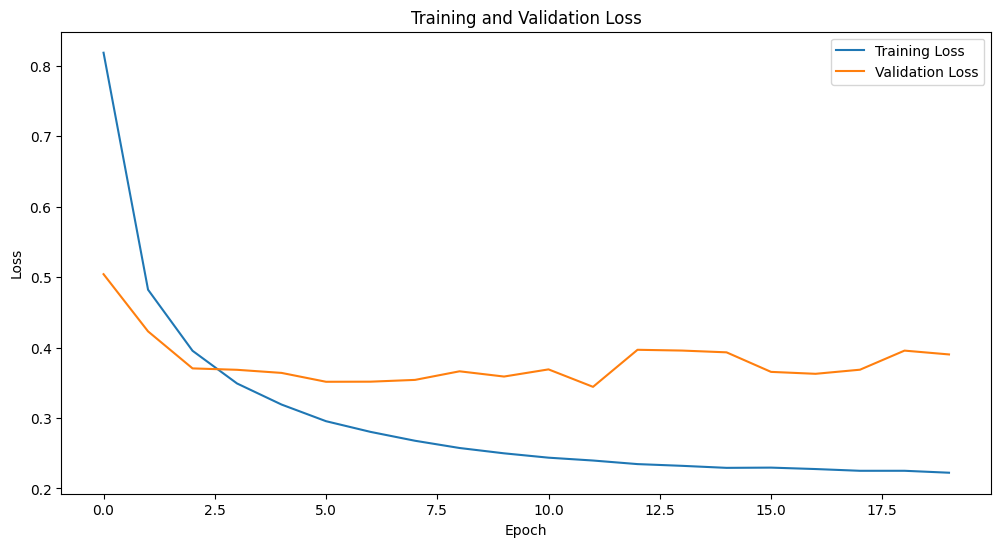

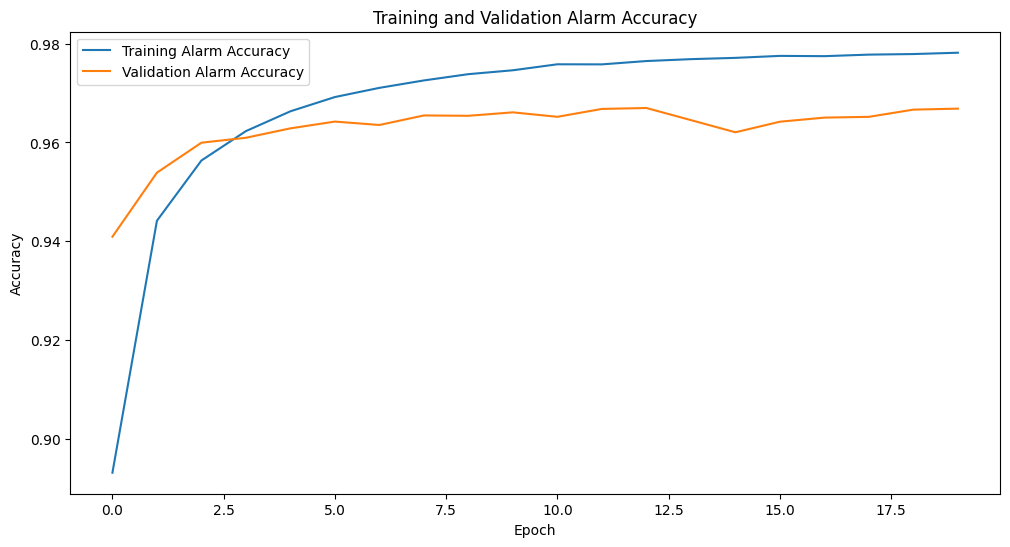

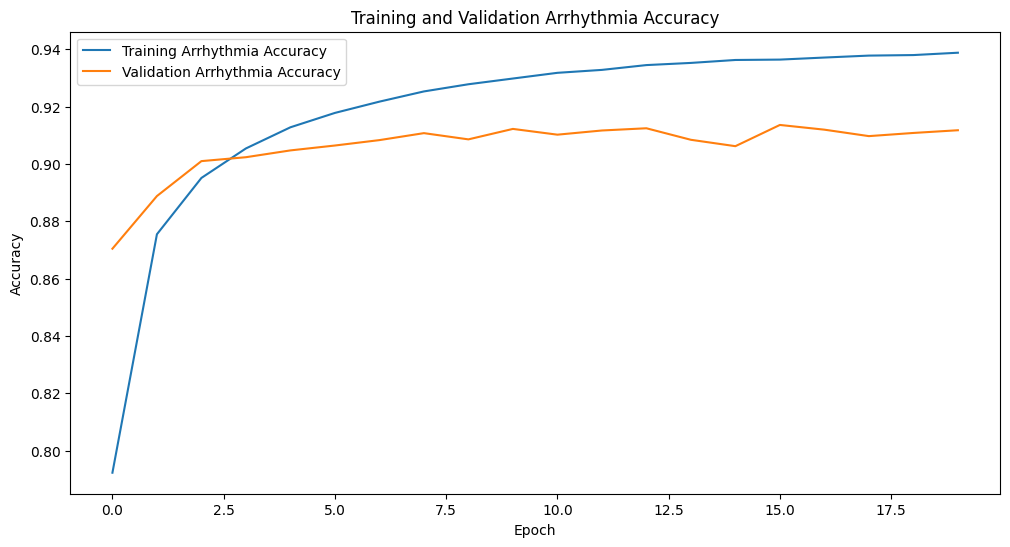

In [ ]:
import matplotlib.pyplot as plt

# Visualizar pérdida
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizar precisión de alarma
plt.figure(figsize=(12, 6))
plt.plot(history.history['alarm_output_accuracy'], label='Training Alarm Accuracy')
plt.plot(history.history['val_alarm_output_accuracy'], label='Validation Alarm Accuracy')
plt.title('Training and Validation Alarm Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizar precisión de arritmia
plt.figure(figsize=(12, 6))
plt.plot(history.history['arrhythmia_output_accuracy'], label='Training Arrhythmia Accuracy')
plt.plot(history.history['val_arrhythmia_output_accuracy'], label='Validation Arrhythmia Accuracy')
plt.title('Training and Validation Arrhythmia Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
